# Import Libraries and Methods

In [3]:
import os
import time
import warnings
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset, WeightedRandomSampler
import torchvision
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Handle Corrupted Images with SafeImageFolder

In [4]:
class SafeImageFolder(ImageFolder):
    """
    An enhanced version of torchvision.datasets.ImageFolder that:
    - Skips unreadable, corrupted, or broken images without crashing
    - Converts palette images with transparency (e.g. certain PNGs) to RGBA format
    This prevents common issues or warnings during model training.
    """

    def __getitem__(self, index):
        try:
            # Load image path and target label
            path, target = self.samples[index]
            sample = self.loader(path)

            # Convert palette images or those with transparency info to RGBA to avoid PIL warning
            if sample.mode == "P" or sample.info.get("transparency") is not None:
                sample = sample.convert("RGBA")

            # Apply transforms if provided
            if self.transform is not None:
                sample = self.transform(sample)
            if self.target_transform is not None:
                target = self.target_transform(target)

            return sample, target

        except (UnidentifiedImageError, OSError, ValueError):
            # Skip unreadable/broken image silently by trying the next one
            return self.__getitem__((index + 1) % len(self))


# Dataset Preparation and Environment Setup

In [5]:
# Transform images: resize to 224x224 (standard for most CNNs) and convert to tensors
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224 pixels
    transforms.ToTensor(),          # Convert PIL image to PyTorch tensor (with values between 0 and 1)
])

# Load dataset using SafeImageFolder (handles corrupted images)
# Assumes each subfolder in 'Incidents-subset' corresponds to a class
dataset = SafeImageFolder(root='Incidents-subset', transform=transform)

# Extract class names and count
class_names = dataset.classes
num_classes = len(class_names)


# Set device to GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Visualize Dataset

Total images: 7308


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training dataset size with KFold=5: 5846
Test dataset size with KFold=5: 1462

Number of classes in the dataset: 12
Classes in the dataset:  ['airplane accident', 'bicycle accident', 'car accident', 'collapsed', 'earthquake', 'flooded', 'ice storm', 'nuclear explosion', 'oil spill', 'tornado', 'volcanic eruption', 'wildfire']
Index of each class:  {'airplane accident': 0, 'bicycle accident': 1, 'car accident': 2, 'collapsed': 3, 'earthquake': 4, 'flooded': 5, 'ice storm': 6, 'nuclear explosion': 7, 'oil spill': 8, 'tornado': 9, 'volcanic eruption': 10, 'wildfire': 11}

Number of images for each label:
Label 0: 874 images
Label 1: 228 images
Label 2: 966 images
Label 3: 631 images
Label 4: 925 images
Label 5: 958 images
Label 6: 615 images
Label 7: 231 images
Label 8: 294 images
Label 9: 281 images
Label 10: 628 images
Label 11: 677 images


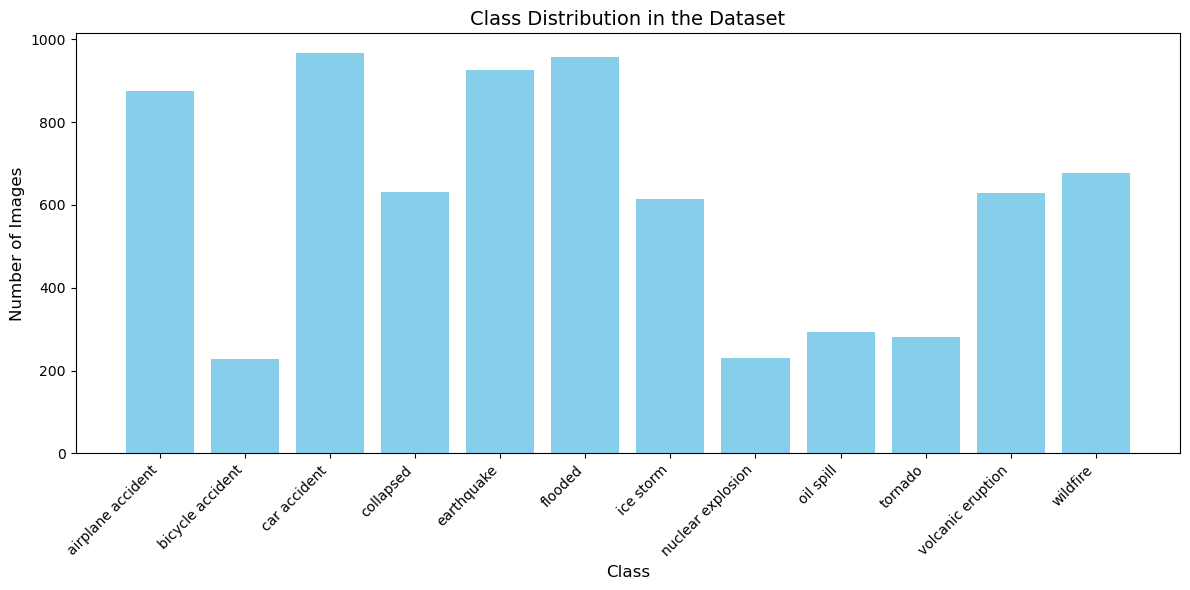


First image in the dataset:
Image shape: torch.Size([3, 224, 224])
Label: 0
Label name: airplane accident


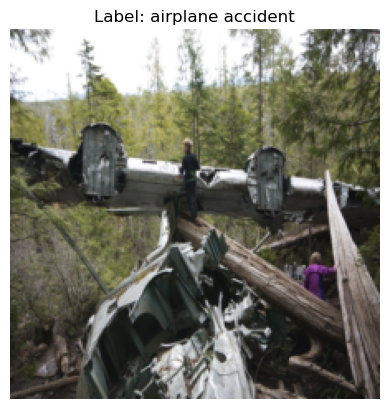

In [6]:
# print the number of images in the training and test sets
print(f"Total images: {len(dataset)}")

# Simulate 1 fold to show train/test sizes for KFold=5
y_all = np.array([label for _, label in dataset])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in skf.split(np.zeros(len(y_all)), y_all):
    print(f"Training dataset size with KFold=5: {len(train_idx)}")
    print(f"Test dataset size with KFold=5: {len(test_idx)}\n")
    break

# print the classes in the dataset
print(f"Number of classes in the dataset: {len(dataset.classes)}")
print(f"Classes in the dataset:  {dataset.classes}")
print(f"Index of each class:  {dataset.class_to_idx}\n")

# Count the number of images for each label in dataset
counter = Counter(dataset.targets)
print("Number of images for each label:")
for label, count in counter.items():
    print(f"Label {label}: {count} images")

# Visualize the class distribution using a bar chart
labels = [dataset.classes[i] for i in counter.keys()]
counts = list(counter.values())

plt.figure(figsize=(12, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Class Distribution in the Dataset', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

# Print the shape of an first image in the dataset add also the label
print("\nFirst image in the dataset:")
image, label = dataset[0]
print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"Label name: {dataset.classes[label]}")

# Display the image
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {dataset.classes[label]}")
plt.axis('off')
plt.show()





/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


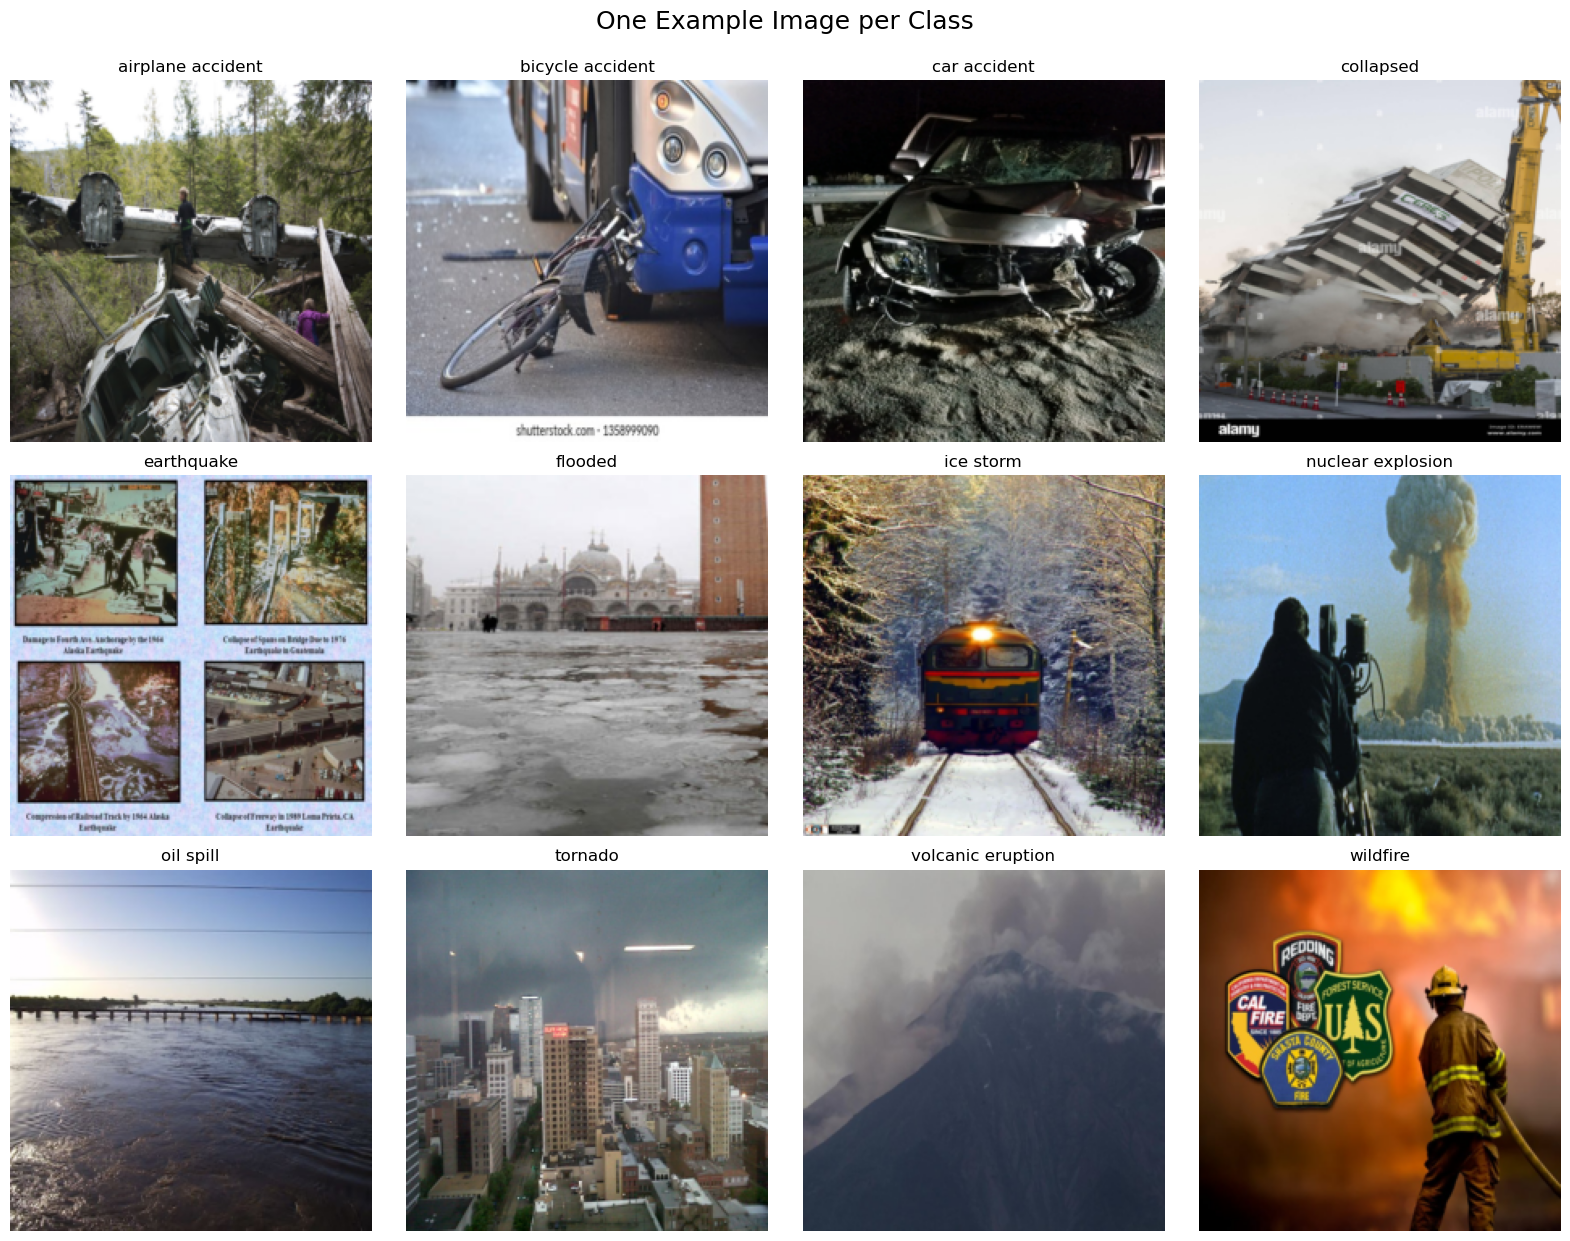

In [7]:
# Show one example image per class in the dataset

# Collect the first encountered image for each class
example_images = {}
for image, label in dataset:
    class_name = dataset.classes[label]
    if class_name not in example_images:
        example_images[class_name] = image
    if len(example_images) == len(dataset.classes):
        break  # Stop once we have one image per class

# Set grid layout for plotting
num_classes = len(example_images)
cols = 4
rows = (num_classes + cols - 1) // cols  # Calculate required rows

plt.figure(figsize=(cols * 4, rows * 4))

# Plot each image with its class name
for i, (class_name, image) in enumerate(sorted(example_images.items())):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(image.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("One Example Image per Class", fontsize=18, y=1.03)
plt.show()



# Evaluation Function

In [8]:
def evaluate_model(y_true, y_pred, class_names=None, model_name="Model"):
    print(f"\nEvaluation Results for {model_name}")
    
    # Compute key metrics
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    # Print metrics
    print(f"Accuracy:                {acc:.4f}")
    print(f"Balanced Accuracy:       {bal_acc:.4f}")
    print(f"Precision (macro):       {precision:.4f}")
    print(f"Recall (macro):          {recall:.4f}")
    print(f"F1 Score (macro):        {f1:.4f}")
    print(f"Matthews Corr. Coeff.:   {mcc:.4f}")
    
    # Classification report (per class)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    
    # Confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# BASELINE MODEL (RANDOM FOREST)

In [9]:
# Extracts a normalized color histogram from a tensor image (C, H, W)
def extract_color_histogram_from_tensor(img_tensor, bins=16):
    img_np = img_tensor.permute(1, 2, 0).numpy()  # Convert to (H, W, C) format
    hist_r, _ = np.histogram(img_np[:, :, 0], bins=bins, range=(0, 1), density=True)
    hist_g, _ = np.histogram(img_np[:, :, 1], bins=bins, range=(0, 1), density=True)
    hist_b, _ = np.histogram(img_np[:, :, 2], bins=bins, range=(0, 1), density=True)
    return np.concatenate([hist_r, hist_g, hist_b])


Running Stratified 5-Fold Cross-Validation with Random Forest (color histograms) 

Processing Fold 1
Time taken for Fold 1: 3.78 seconds

Processing Fold 2
Time taken for Fold 2: 3.69 seconds

Processing Fold 3
Time taken for Fold 3: 3.71 seconds

Processing Fold 4
Time taken for Fold 4: 3.82 seconds

Processing Fold 5
Time taken for Fold 5: 3.80 seconds

Total time for all folds: 18.80 seconds

Evaluation Results for Random Forest
Accuracy:                0.3618
Balanced Accuracy:       0.2873
Precision (macro):       0.3699
Recall (macro):          0.2873
F1 Score (macro):        0.2793
Matthews Corr. Coeff.:   0.2824

Classification Report:
                   precision    recall  f1-score   support

airplane accident       0.31      0.32      0.32       874
 bicycle accident       0.27      0.02      0.03       228
     car accident       0.35      0.55      0.43       966
        collapsed       0.22      0.10      0.13       631
       earthquake       0.32      0.46      0.38    

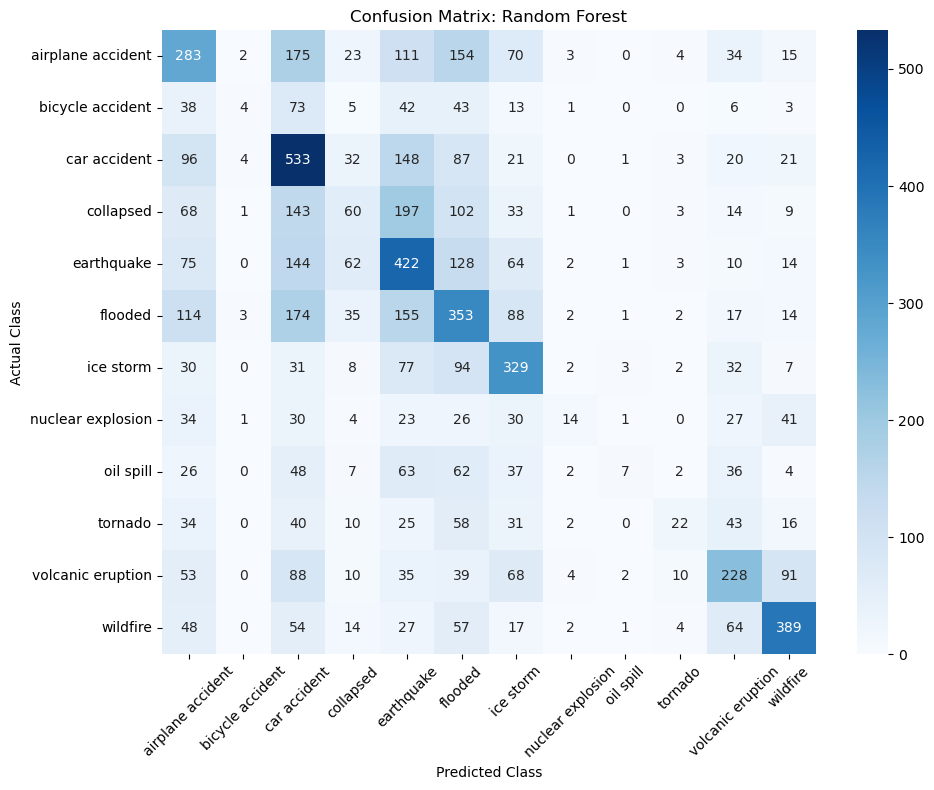

In [8]:
# Extract color histogram features and labels from the dataset
X_all, y_all = [], []
for img, label in dataset:
    feature = extract_color_histogram_from_tensor(img, bins=16)
    X_all.append(feature)
    y_all.append(label)

X_all = np.array(X_all)
y_all = np.array(y_all)

# Stratified 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_y_true = []
all_y_pred = []

print("Running Stratified 5-Fold Cross-Validation with Random Forest (color histograms) \n")

# Start total timer
total_start_time = time.time()

for fold, (train_idx, test_idx) in enumerate(skf.split(X_all, y_all)):
    print(f"Processing Fold {fold + 1}")
    fold_start_time = time.time()

    # Split features and labels for current fold
    X_train, X_test = X_all[train_idx], X_all[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]

    # Train a Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Predict on the test split
    y_pred = clf.predict(X_test)

    # Store predictions for evaluation
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # End fold timer
    fold_end_time = time.time()
    fold_duration = fold_end_time - fold_start_time
    print(f"Time taken for Fold {fold + 1}: {fold_duration:.2f} seconds\n")

# End total timer
total_end_time = time.time()
total_duration = total_end_time - total_start_time
print(f"Total time for all folds: {total_duration:.2f} seconds")

# Evaluate model performance across all folds
evaluate_model(all_y_true, all_y_pred, class_names=class_names, model_name="Random Forest")



# Functions for Deep Learning Models

In [10]:
def train_with_kfold(model_name, model_fn, adjust_classifier_fn, dataset, class_names, num_classes, device, batch_size=32, epochs=5):
    print(f"\nStarting Stratified 5-Fold Cross-Validation for {model_name}")

    # Extract all images and labels
    X_all = [img for img, label in dataset]
    y_all = [label for _, label in dataset]
    y_all = np.array(y_all)

    # Create Stratified K-Fold splitter
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    all_y_true = []
    all_y_pred = []

    total_start_time = time.time()

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_all, y_all)):
        fold_start_time = time.time()
        print(f"\nFold {fold + 1}")

        # Subset data for this fold
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        test_subset = torch.utils.data.Subset(dataset, test_idx)

        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

        # Load model and adjust classifier
        model = model_fn(pretrained=True)
        model = adjust_classifier_fn(model, num_classes)
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

        # Training
        model.train()
        for epoch in range(epochs):
            running_loss, correct, total = 0.0, 0, 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = correct / total
            print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")

        # Evaluation
        model.eval()
        y_true_fold, y_pred_fold = [], []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                y_true_fold.extend(labels.numpy())
                y_pred_fold.extend(preds.cpu().numpy())

        all_y_true.extend(y_true_fold)
        all_y_pred.extend(y_pred_fold)

        fold_end_time = time.time()
        print(f"Time taken for Fold {fold + 1}: {fold_end_time - fold_start_time:.2f} seconds")

    total_time = time.time() - total_start_time
    print(f"\nTotal time for all folds: {total_time:.2f} seconds")

    print(f"\nFinal Evaluation for {model_name} (5-Fold Average):")
    evaluate_model(all_y_true, all_y_pred, class_names=class_names, model_name=model_name)

In [11]:
# For ResNet18
def adjust_resnet(model, num_classes):
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# For EfficientNet-B0
def adjust_efficientnet(model, num_classes):
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

# For DenseNet121
def adjust_densenet(model, num_classes):
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model


# RESNET18 MODEL


Starting Stratified 5-Fold Cross-Validation for ResNet18


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Fold 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5 - Loss: 1.3614 - Accuracy: 0.5869
Epoch 2/5 - Loss: 0.8092 - Accuracy: 0.7523
Epoch 3/5 - Loss: 0.6918 - Accuracy: 0.7821
Epoch 4/5 - Loss: 0.6442 - Accuracy: 0.7887
Epoch 5/5 - Loss: 0.6034 - Accuracy: 0.8036
Time taken for Fold 1: 584.99 seconds

Fold 2
Epoch 1/5 - Loss: 1.3687 - Accuracy: 0.5850
Epoch 2/5 - Loss: 0.8018 - Accuracy: 0.7592
Epoch 3/5 - Loss: 0.6893 - Accuracy: 0.7841
Epoch 4/5 - Loss: 0.6342 - Accuracy: 0.7940
Epoch 5/5 - Loss: 0.5803 - Accuracy: 0.8183
Time taken for Fold 2: 566.41 seconds

Fold 3
Epoch 1/5 - Loss: 1.3680 - Accuracy: 0.5864
Epoch 2/5 - Loss: 0.8184 - Accuracy: 0.7521
Epoch 3/5 - Loss: 0.7023 - Accuracy: 0.7807
Epoch 4/5 - Loss: 0.6626 - Accuracy: 0.7838
Epoch 5/5 - Loss: 0.6140 - Accuracy: 0.8005
Time taken for Fold 3: 558.24 seconds

Fold 4
Epoch 1/5 - Loss: 1.3712 - Accuracy: 0.5888
Epoch 2/5 - Loss: 0.8196 - Accuracy: 0.7486
Epoch 3/5 - Loss: 0.7028 - Accuracy: 0.7782
Epoch 4/5 - Loss: 0.6462 - Accuracy: 0.7912
Epoch 5/5 - Loss: 0.6104 -

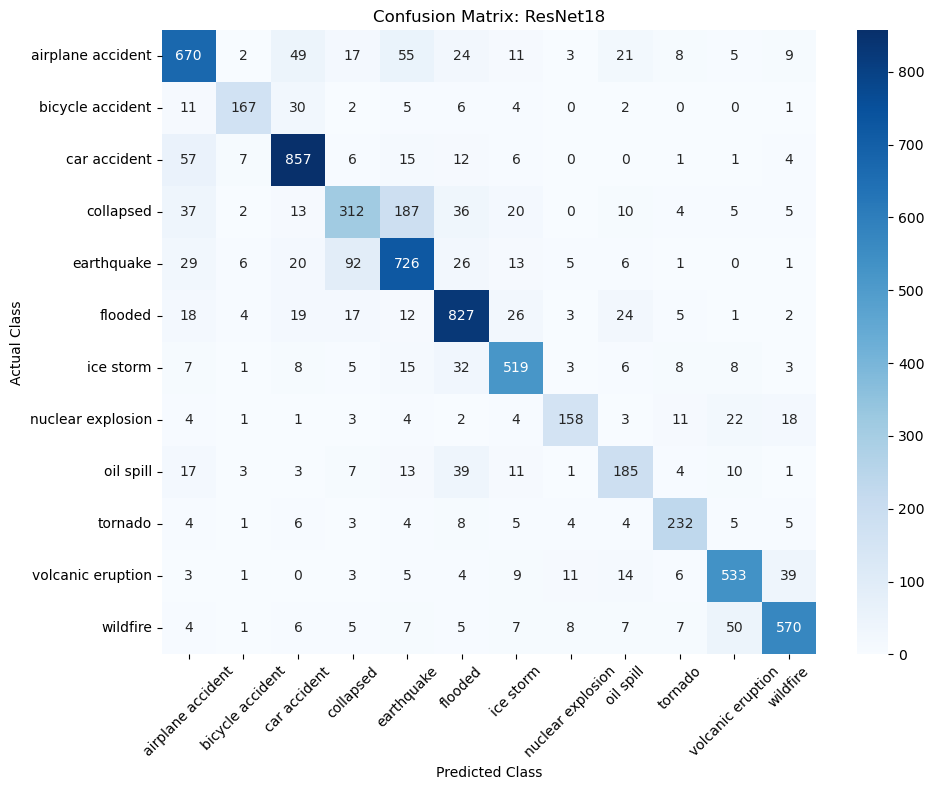

In [16]:
from torchvision import models

train_with_kfold(
    model_name="ResNet18",
    model_fn=models.resnet18,
    adjust_classifier_fn=adjust_resnet,
    dataset=dataset,
    class_names=class_names,
    num_classes=num_classes,
    device=device,
    batch_size=32,
    epochs=5
)


# EfficientNet B0 MODEL


Starting Stratified 5-Fold Cross-Validation for EfficientNet-B0


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Fold 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5 - Loss: 1.3068 - Accuracy: 0.6139
Epoch 2/5 - Loss: 0.8568 - Accuracy: 0.7280
Epoch 3/5 - Loss: 0.7922 - Accuracy: 0.7479
Epoch 4/5 - Loss: 0.7321 - Accuracy: 0.7605
Epoch 5/5 - Loss: 0.6953 - Accuracy: 0.7754
Time taken for Fold 1: 593.18 seconds

Fold 2
Epoch 1/5 - Loss: 1.3055 - Accuracy: 0.6192
Epoch 2/5 - Loss: 0.8694 - Accuracy: 0.7278
Epoch 3/5 - Loss: 0.7693 - Accuracy: 0.7528
Epoch 4/5 - Loss: 0.7267 - Accuracy: 0.7680
Epoch 5/5 - Loss: 0.6916 - Accuracy: 0.7723
Time taken for Fold 2: 600.00 seconds

Fold 3
Epoch 1/5 - Loss: 1.3039 - Accuracy: 0.6086
Epoch 2/5 - Loss: 0.8777 - Accuracy: 0.7198
Epoch 3/5 - Loss: 0.7864 - Accuracy: 0.7508
Epoch 4/5 - Loss: 0.7308 - Accuracy: 0.7629
Epoch 5/5 - Loss: 0.6963 - Accuracy: 0.7684
Time taken for Fold 3: 589.55 seconds

Fold 4
Epoch 1/5 - Loss: 1.2990 - Accuracy: 0.6107
Epoch 2/5 - Loss: 0.8625 - Accuracy: 0.7327
Epoch 3/5 - Loss: 0.7643 - Accuracy: 0.7577
Epoch 4/5 - Loss: 0.7184 - Accuracy: 0.7695
Epoch 5/5 - Loss: 0.6999 -

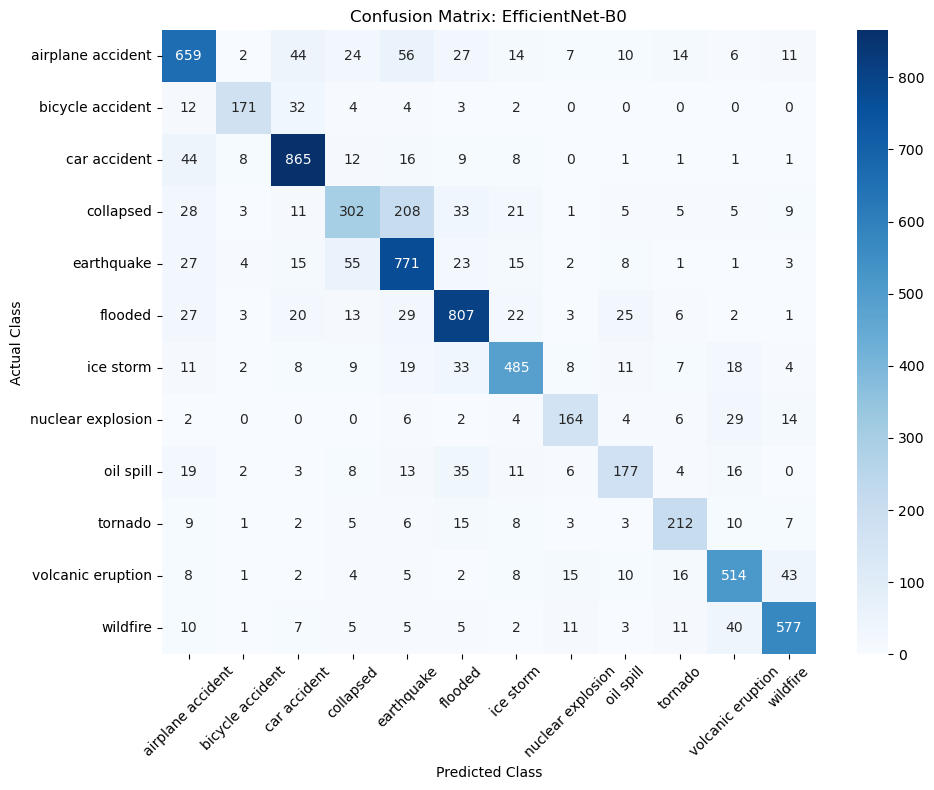

In [17]:
train_with_kfold(
    model_name="EfficientNet-B0",
    model_fn=models.efficientnet_b0,
    adjust_classifier_fn=adjust_efficientnet,
    dataset=dataset,
    class_names=class_names,
    num_classes=num_classes,
    device=device,
    batch_size=16,
    epochs=5
)


# DenseNet121 MODEL


Starting Stratified 5-Fold Cross-Validation for DenseNet121


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Fold 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5 - Loss: 1.1982 - Accuracy: 0.6315
Epoch 2/5 - Loss: 0.7383 - Accuracy: 0.7679
Epoch 3/5 - Loss: 0.6436 - Accuracy: 0.7949
Epoch 4/5 - Loss: 0.5999 - Accuracy: 0.8031
Epoch 5/5 - Loss: 0.5788 - Accuracy: 0.8091
Time taken for Fold 1: 650.35 seconds

Fold 2
Epoch 1/5 - Loss: 1.1920 - Accuracy: 0.6444
Epoch 2/5 - Loss: 0.7411 - Accuracy: 0.7646
Epoch 3/5 - Loss: 0.6296 - Accuracy: 0.7978
Epoch 4/5 - Loss: 0.5957 - Accuracy: 0.8086
Epoch 5/5 - Loss: 0.5543 - Accuracy: 0.8190
Time taken for Fold 2: 639.64 seconds

Fold 3
Epoch 1/5 - Loss: 1.2387 - Accuracy: 0.6257
Epoch 2/5 - Loss: 0.7355 - Accuracy: 0.7663
Epoch 3/5 - Loss: 0.6537 - Accuracy: 0.7879
Epoch 4/5 - Loss: 0.6099 - Accuracy: 0.8004
Epoch 5/5 - Loss: 0.5640 - Accuracy: 0.8197
Time taken for Fold 3: 656.23 seconds

Fold 4
Epoch 1/5 - Loss: 1.2415 - Accuracy: 0.6130
Epoch 2/5 - Loss: 0.7547 - Accuracy: 0.7604
Epoch 3/5 - Loss: 0.6583 - Accuracy: 0.7890
Epoch 4/5 - Loss: 0.6043 - Accuracy: 0.8035
Epoch 5/5 - Loss: 0.5612 -

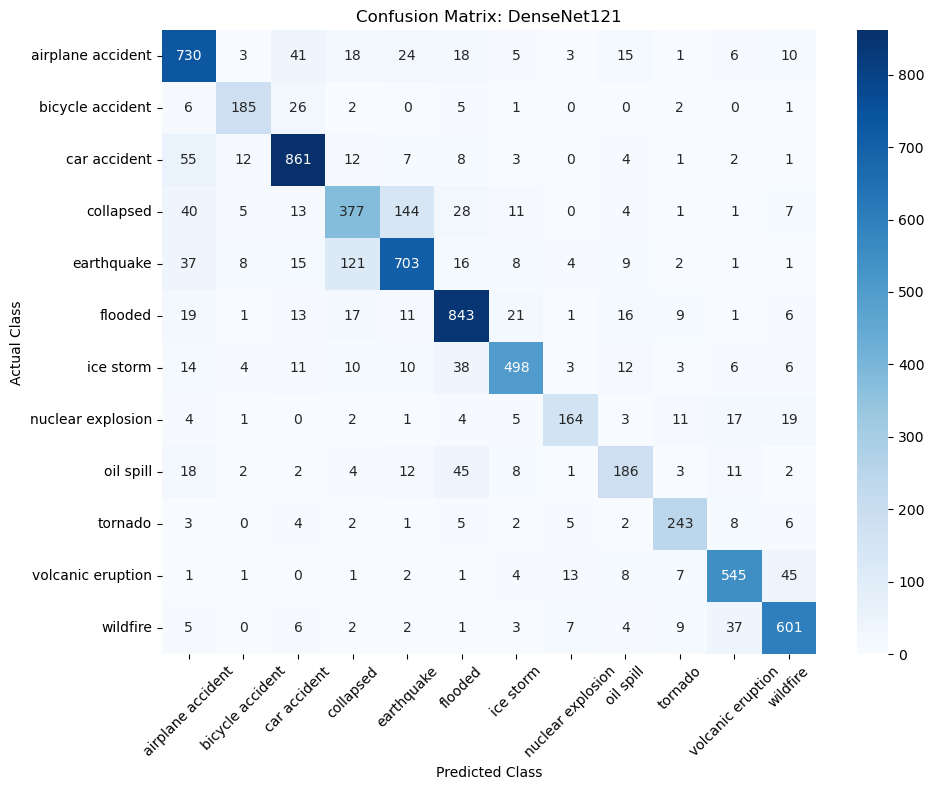

In [12]:
train_with_kfold(
    model_name="DenseNet121",
    model_fn=models.densenet121,
    adjust_classifier_fn=adjust_densenet,
    dataset=dataset,
    class_names=class_names,
    num_classes=num_classes,
    device=device,
    batch_size=16,
    epochs=5
)

# BASELINE MODE with OVERSAMPLING (RANDOM FOREST)

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Running Stratified 5-Fold Cross-Validation with Random Forest (OVERSAMPLED color histograms) 

Processing Fold 1
Time taken for Fold 1: 5.42 seconds

Processing Fold 2
Time taken for Fold 2: 5.31 seconds

Processing Fold 3
Time taken for Fold 3: 5.24 seconds

Processing Fold 4
Time taken for Fold 4: 5.29 seconds

Processing Fold 5
Time taken for Fold 5: 5.29 seconds

Total time for all folds: 26.55 seconds

Evaluation Results for Random Forest (Oversampled)
Accuracy:                0.3559
Balanced Accuracy:       0.3043
Precision (macro):       0.3277
Recall (macro):          0.3043
F1 Score (macro):        0.3054
Matthews Corr. Coeff.:   0.2791

Classification Report:
                   precision    recall  f1-score   support

airplane accident       0.34      0.32      0.33       874
 bicycle accident       0.22      0.11      0.14       228
     car accident       0.35      0.49      0.41       966
        collapsed       0.22      0.15      0.18       631
       earthquake       0.

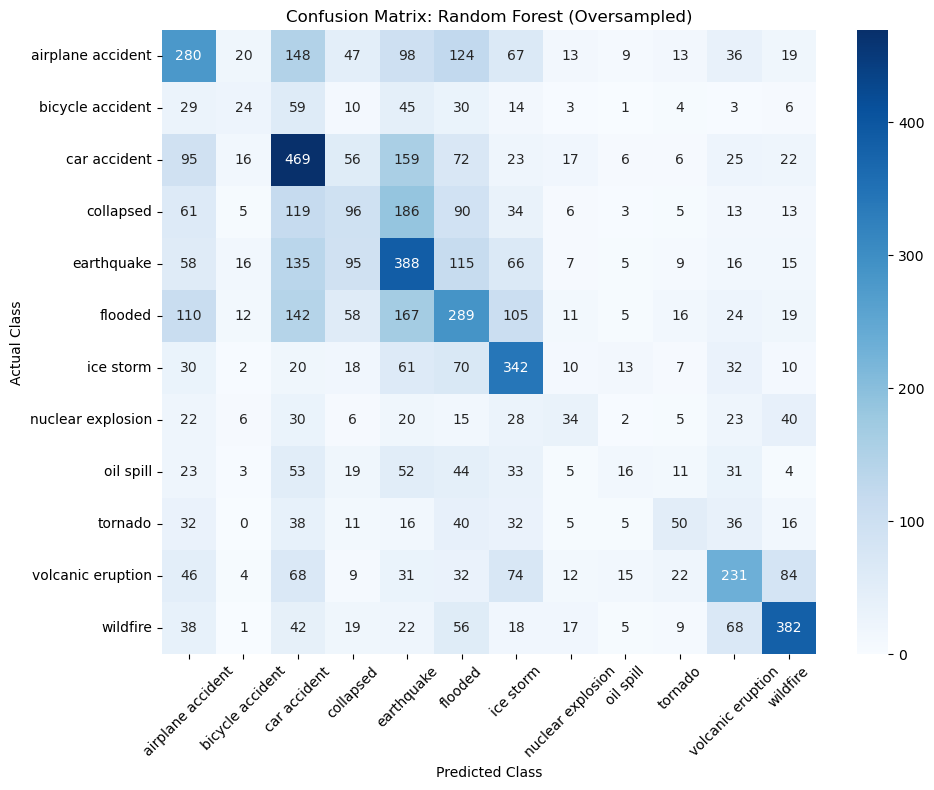

In [18]:
# Feature extraction for Random Forest only
X_all, y_all = [], []
for img, label in dataset:
    feature = extract_color_histogram_from_tensor(img, bins=16)
    X_all.append(feature)
    y_all.append(label)

X_all = np.array(X_all)
y_all = np.array(y_all)

# Stratified 5-Fold Cross-Validation

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_y_true = []
all_y_pred = []

print("Running Stratified 5-Fold Cross-Validation with Random Forest (OVERSAMPLED color histograms) \n")

# Start total timer
total_start_time = time.time()

for fold, (train_idx, test_idx) in enumerate(skf.split(X_all, y_all)):
    print(f"Processing Fold {fold + 1}")
    fold_start_time = time.time()

    # Split features and labels for current fold
    X_train, X_test = X_all[train_idx], X_all[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]

    # Oversampling only on training data
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

    # Train a Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_resampled, y_train_resampled)

    # Predict on the test split
    y_pred = clf.predict(X_test)

    # Store predictions for evaluation
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # End fold timer
    fold_end_time = time.time()
    fold_duration = fold_end_time - fold_start_time
    print(f"Time taken for Fold {fold + 1}: {fold_duration:.2f} seconds\n")

# End total timer
total_end_time = time.time()
total_duration = total_end_time - total_start_time
print(f"Total time for all folds: {total_duration:.2f} seconds")

# Evaluate model performance across all folds
evaluate_model(all_y_true, all_y_pred, class_names=class_names, model_name="Random Forest (Oversampled)")


# New train_with_kfold function for Deep Learning Models

In [12]:
def train_with_kfold_oversample(model_name, model_fn, adjust_classifier_fn, dataset, class_names, num_classes, device, batch_size=32, epochs=5):
    print(f"\nStarting Stratified 5-Fold Cross-Validation with Oversampling for {model_name}")

    # Extract labels for stratification
    X_all = [img for img, label in dataset]
    y_all = [label for _, label in dataset]
    y_all = np.array(y_all)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    all_y_true = []
    all_y_pred = []

    total_start_time = time.time()

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_all, y_all)):
        fold_start_time = time.time()
        print(f"\nFold {fold + 1}")

        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)

        # Create oversampled sampler
        labels = [dataset[i][1] for i in train_subset.indices]
        class_counts = Counter(labels)
        class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
        sample_weights = [class_weights[label] for label in labels]
        sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

        train_loader = DataLoader(train_subset, batch_size=batch_size, sampler=sampler)
        test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

        # Load and prepare model
        model = model_fn(pretrained=True)
        model = adjust_classifier_fn(model, num_classes)
        model = model.to(device)

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

        # Training
        model.train()
        for epoch in range(epochs):
            running_loss, correct, total = 0.0, 0, 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = correct / total
            print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")

        # Evaluation
        model.eval()
        y_true_fold, y_pred_fold = [], []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                y_true_fold.extend(labels.numpy())
                y_pred_fold.extend(preds.cpu().numpy())

        all_y_true.extend(y_true_fold)
        all_y_pred.extend(y_pred_fold)

        fold_end_time = time.time()
        print(f"Time taken for Fold {fold + 1}: {fold_end_time - fold_start_time:.2f} seconds")

    total_time = time.time() - total_start_time
    print(f"\nTotal time for all folds: {total_time:.2f} seconds")
    print(f"\nFinal Evaluation for {model_name} (5-Fold Average):")
    evaluate_model(all_y_true, all_y_pred, class_names=class_names, model_name=model_name)

# RESNET18 MODEL with OVERSAMPLING


Starting Stratified 5-Fold Cross-Validation with Oversampling for ResNet18 with Oversampling


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Fold 1


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 - Loss: 1.4146 - Accuracy: 0.5775
Epoch 2/5 - Loss: 0.8039 - Accuracy: 0.7646
Epoch 3/5 - Loss: 0.6953 - Accuracy: 0.7875
Epoch 4/5 - Loss: 0.6270 - Accuracy: 0.8052
Epoch 5/5 - Loss: 0.5688 - Accuracy: 0.8206
Time taken for Fold 1: 631.52 seconds

Fold 2
Epoch 1/5 - Loss: 1.4062 - Accuracy: 0.5915
Epoch 2/5 - Loss: 0.7825 - Accuracy: 0.7668
Epoch 3/5 - Loss: 0.6593 - Accuracy: 0.8017
Epoch 4/5 - Loss: 0.5872 - Accuracy: 0.8173
Epoch 5/5 - Loss: 0.5778 - Accuracy: 0.8120
Time taken for Fold 2: 639.42 seconds

Fold 3
Epoch 1/5 - Loss: 1.3939 - Accuracy: 0.5913
Epoch 2/5 - Loss: 0.8070 - Accuracy: 0.7651
Epoch 3/5 - Loss: 0.6788 - Accuracy: 0.7961
Epoch 4/5 - Loss: 0.6286 - Accuracy: 0.8052
Epoch 5/5 - Loss: 0.5883 - Accuracy: 0.8137
Time taken for Fold 3: 616.16 seconds

Fold 4
Epoch 1/5 - Loss: 1.3911 - Accuracy: 0.5873
Epoch 2/5 - Loss: 0.7908 - Accuracy: 0.7732
Epoch 3/5 - Loss: 0.6880 - Accuracy: 0.7927
Epoch 4/5 - Loss: 0.6158 - Accuracy: 0.8078
Epoch 5/5 - Loss: 0.5887 -

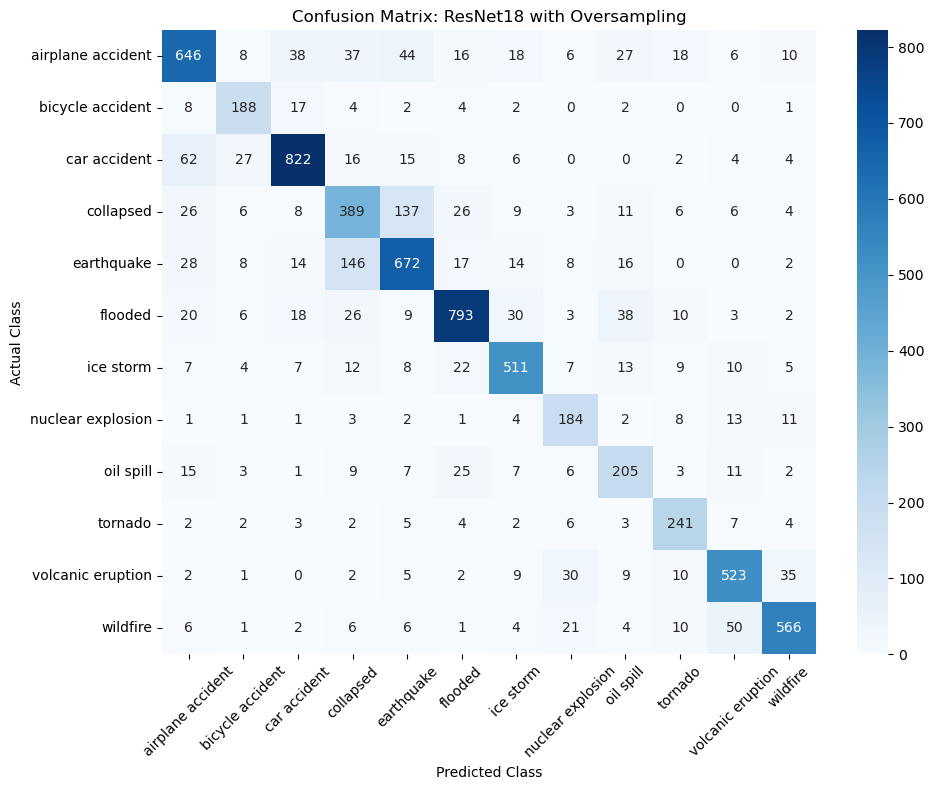

In [22]:
train_with_kfold_oversample(
    model_name="ResNet18 with Oversampling",
    model_fn=models.resnet18,
    adjust_classifier_fn=adjust_resnet,
    dataset=dataset,
    class_names=class_names,
    num_classes=num_classes,
    device=device,
    batch_size=32,
    epochs=5
)

# EfficientNet B0 MODEL with OVERSAMPLING


Starting Stratified 5-Fold Cross-Validation with Oversampling for EfficientNet-B0 with Oversampling


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Fold 1


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 - Loss: 1.2909 - Accuracy: 0.6413
Epoch 2/5 - Loss: 0.8644 - Accuracy: 0.7381
Epoch 3/5 - Loss: 0.7301 - Accuracy: 0.7797
Epoch 4/5 - Loss: 0.6913 - Accuracy: 0.7848
Epoch 5/5 - Loss: 0.6727 - Accuracy: 0.7889
Time taken for Fold 1: 658.20 seconds

Fold 2
Epoch 1/5 - Loss: 1.2978 - Accuracy: 0.6321
Epoch 2/5 - Loss: 0.8490 - Accuracy: 0.7354
Epoch 3/5 - Loss: 0.7373 - Accuracy: 0.7641
Epoch 4/5 - Loss: 0.6917 - Accuracy: 0.7840
Epoch 5/5 - Loss: 0.6418 - Accuracy: 0.7928
Time taken for Fold 2: 677.63 seconds

Fold 3
Epoch 1/5 - Loss: 1.2910 - Accuracy: 0.6367
Epoch 2/5 - Loss: 0.8324 - Accuracy: 0.7436
Epoch 3/5 - Loss: 0.7654 - Accuracy: 0.7559
Epoch 4/5 - Loss: 0.6963 - Accuracy: 0.7757
Epoch 5/5 - Loss: 0.6789 - Accuracy: 0.7838
Time taken for Fold 3: 664.45 seconds

Fold 4
Epoch 1/5 - Loss: 1.3100 - Accuracy: 0.6289
Epoch 2/5 - Loss: 0.8374 - Accuracy: 0.7426
Epoch 3/5 - Loss: 0.7523 - Accuracy: 0.7597
Epoch 4/5 - Loss: 0.6932 - Accuracy: 0.7807
Epoch 5/5 - Loss: 0.6474 -

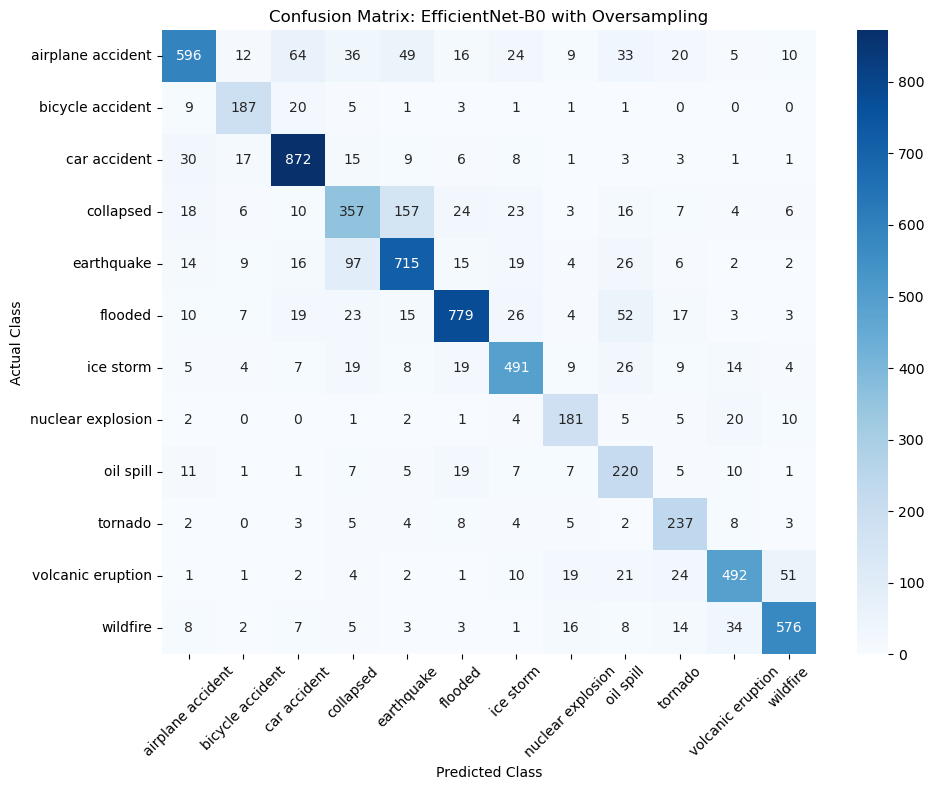

In [23]:
train_with_kfold_oversample(
    model_name="EfficientNet-B0 with Oversampling",
    model_fn=models.efficientnet_b0,
    adjust_classifier_fn=adjust_efficientnet,
    dataset=dataset,
    class_names=class_names,
    num_classes=num_classes,
    device=device,
    batch_size=16,
    epochs=5
)


# DenseNet121 MODEL with OVERSAMPLING


Starting Stratified 5-Fold Cross-Validation with Oversampling for DenseNet121 with Oversampling

Fold 1


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 - Loss: 1.2222 - Accuracy: 0.6425
Epoch 2/5 - Loss: 0.7246 - Accuracy: 0.7761
Epoch 3/5 - Loss: 0.6254 - Accuracy: 0.8069
Epoch 4/5 - Loss: 0.5672 - Accuracy: 0.8154
Epoch 5/5 - Loss: 0.5597 - Accuracy: 0.8214
Time taken for Fold 1: 730.34 seconds

Fold 2
Epoch 1/5 - Loss: 1.1913 - Accuracy: 0.6502
Epoch 2/5 - Loss: 0.6980 - Accuracy: 0.7867
Epoch 3/5 - Loss: 0.6160 - Accuracy: 0.8084
Epoch 4/5 - Loss: 0.5424 - Accuracy: 0.8319
Epoch 5/5 - Loss: 0.5283 - Accuracy: 0.8319
Time taken for Fold 2: 732.32 seconds

Fold 3
Epoch 1/5 - Loss: 1.2089 - Accuracy: 0.6452
Epoch 2/5 - Loss: 0.7402 - Accuracy: 0.7715
Epoch 3/5 - Loss: 0.6236 - Accuracy: 0.8062
Epoch 4/5 - Loss: 0.5819 - Accuracy: 0.8182
Epoch 5/5 - Loss: 0.5623 - Accuracy: 0.8187
Time taken for Fold 3: 739.82 seconds

Fold 4
Epoch 1/5 - Loss: 1.2470 - Accuracy: 0.6354
Epoch 2/5 - Loss: 0.7340 - Accuracy: 0.7724
Epoch 3/5 - Loss: 0.6175 - Accuracy: 0.8067
Epoch 4/5 - Loss: 0.5719 - Accuracy: 0.8124
Epoch 5/5 - Loss: 0.5330 -

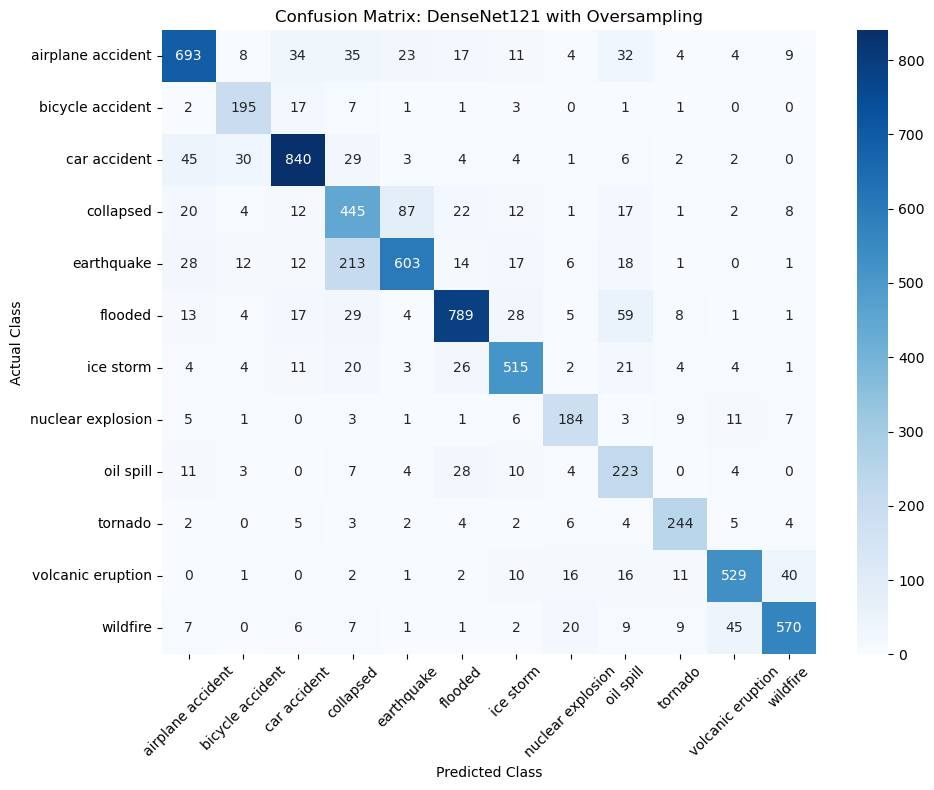

In [13]:
train_with_kfold_oversample(
    model_name="DenseNet121 with Oversampling",
    model_fn=models.densenet121,
    adjust_classifier_fn=adjust_densenet,
    dataset=dataset,
    class_names=class_names,
    num_classes=num_classes,
    device=device,
    batch_size=16,
    epochs=5
)